<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width="200" alt="cognitiveclass.ai logo" /> 

<h1>Deeper Neural Networks with nn.ModuleList()</h1>

<h2>Table of Contents</h2>
<p>In this lab, you will create a Deeper Neural Network with <code>nn.ModuleList()</code></p>

<ul>
    <li><a href="#Model">Neural Network Module and Function for Training</a></li>
    <li><a href="#Train">Train and Validate the Model</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

<h2>Preparation</h2>

We'll need the following libraries

In [1]:
# Import the libraries we need for this lab

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

Function used to plot:

In [2]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

Create Dataset <code>Class</code>

In [3]:
# Create Data Class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

<!--Empty Space for separating topics-->

<h2 id="Model">Neural Network Module and Function for Training</h2>

Neural Network Module using <code>ModuleList()</code>

In [4]:
# Create Net model class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
        return activation

A function used to train. 

In [5]:
# Define the function for training the model

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.item())
        ACC.append(accuracy(model, data_set))
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

A function used to calculate accuracy 

In [6]:
# The function to calculate the accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

<!--Empty Space for separating topics-->

<h2 id="Train">Train and Validate the Model</h2>

Crate a dataset object:

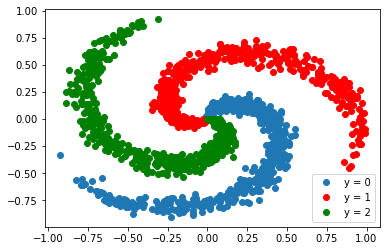

In [7]:
# Create a Dataset object

data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

Create a  network to classify three classes with 1 hidden layer with 50 neurons 

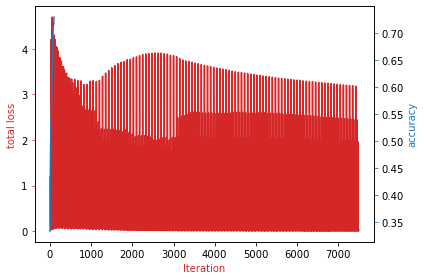

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


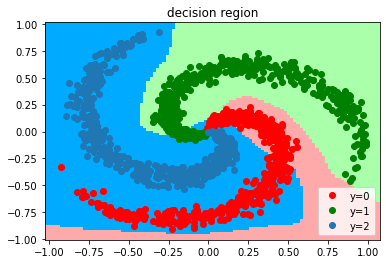

In [8]:
# Train the model with 1 hidden layer with 50 neurons

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

plot_decision_regions_3class(model, data_set)

Create a  network to classify three classes with 2 hidden layers with 20 neurons in total 

In [15]:
Net([3,3,4,3]).parameters

<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=3, bias=True)
  )
)>

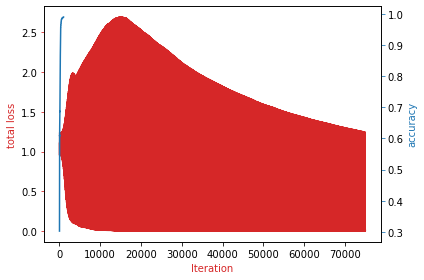

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


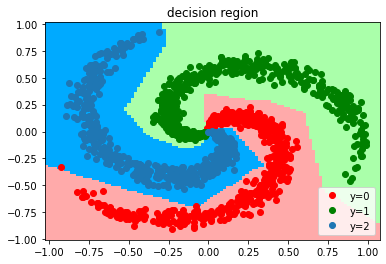

In [9]:
# Train the model with 2 hidden layers with 20 neurons

Layers = [2, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=1000)

plot_decision_regions_3class(model, data_set)

<h3>Practice</h3>

Create a network with three hidden layers each with ten neurons, then train the network using the same process as above 

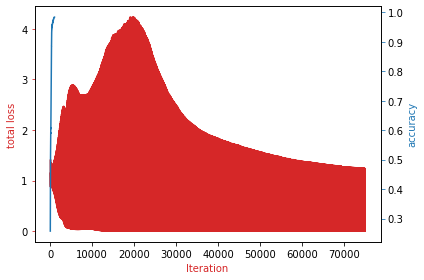

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


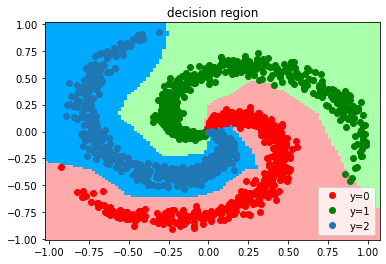

In [10]:
# Practice: Create a network with three hidden layers each with ten neurons.

Layers = [2, 10, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 1000)
plot_decision_regions_3class(model, data_set)

Double-click <b>here</b> for the solution.

<!-- 
Layers = [2, 10, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 1000)
plot_decision_regions_3class(model, data_set)
-->

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.